In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from PIL import Image, ImageChops, ImageEnhance
import os 
import joblib


In [12]:
PATH_IMG = '/kaggle/input/casia-dataset/CASIA2/'


In [13]:
import os
import pandas as pd
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []
for label in data_label:
    # print(label)
    # print(os.listdir(PATH_IMG+label))
    for img_file in os.listdir(PATH_IMG+label):
        img_lst.append(PATH_IMG+label+'/'+img_file)
        label_lst.append(label)
    # print(label_lst)


df = pd.DataFrame({'img': img_lst, 'label': label_lst})
df.head()

,img,label
0,/kaggle/input/casia-dataset/CASIA2/Au/Au_pla_3...,Au
1,/kaggle/input/casia-dataset/CASIA2/Au/Au_ani_1...,Au
2,/kaggle/input/casia-dataset/CASIA2/Au/Au_nat_0...,Au
3,/kaggle/input/casia-dataset/CASIA2/Au/Au_nat_3...,Au
4,/kaggle/input/casia-dataset/CASIA2/Au/Au_arc_2...,Au


In [14]:
import os
from PIL import Image, UnidentifiedImageError

PATH_RESAVED = '/kaggle/working/resave/'
os.makedirs(PATH_RESAVED, exist_ok=True)

def resave(quality):
    for index, row in df.iterrows():
        img_file = row['img']
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp', '.gif')):
            try:
                img = Image.open(img_file).convert('RGB')
                img_file_name = os.path.basename(img_file)
                resaved_name = os.path.splitext(img_file_name)[0] + 'resaved' + '.jpg'
                img.save(os.path.join(PATH_RESAVED, resaved_name), 'JPEG', quality=quality, optimize=True)
            except UnidentifiedImageError:
                print(f"Cannot identify image file {img_file}")
        else:
            print(f"Skipping non-image file {img_file}")

# Run the function with the desired quality
resave(90)


Skipping non-image file /kaggle/input/casia-dataset/CASIA2/Au/Thumbs.db
Skipping non-image file /kaggle/input/casia-dataset/CASIA2/Tp/Thumbs.db


In [15]:
df['img_resaved'] = df['img'].apply(lambda x: PATH_RESAVED+ x.split('/')[-1].split('.')[0] + 'resaved' + '.jpg')
df.head()

,img,label,img_resaved
0,/kaggle/input/casia-dataset/CASIA2/Au/Au_pla_3...,Au,/kaggle/working/resave/Au_pla_30322resaved.jpg
1,/kaggle/input/casia-dataset/CASIA2/Au/Au_ani_1...,Au,/kaggle/working/resave/Au_ani_10197resaved.jpg
2,/kaggle/input/casia-dataset/CASIA2/Au/Au_nat_0...,Au,/kaggle/working/resave/Au_nat_00098resaved.jpg
3,/kaggle/input/casia-dataset/CASIA2/Au/Au_nat_3...,Au,/kaggle/working/resave/Au_nat_30407resaved.jpg
4,/kaggle/input/casia-dataset/CASIA2/Au/Au_arc_2...,Au,/kaggle/working/resave/Au_arc_20034resaved.jpg


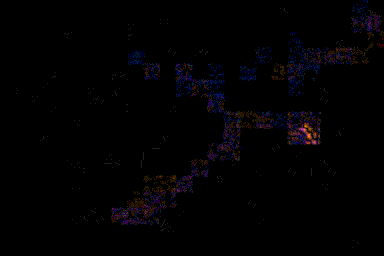

In [16]:
from PIL import Image, ImageChops,ImageEnhance, UnidentifiedImageError

def img_difference(org, resaved):
    org_img = Image.open(org).convert('RGB')
    resaved_img = Image.open(resaved)
    try:
        
        diff = ImageChops.difference(org_img, resaved_img)
    except Exception as e:
        print(org, resaved)
        print(e)
        return None
    # diff= ImageEnhance.Brightness(diff).enhance(250.0)
    extrema = diff.getextrema()
    # print(extrema)
    # lst = [ex[1] for ex in extrema]
    max_diff = max([ex[1] for ex in extrema])
    # print(lst, max_diff)
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)
    enhancer = ImageEnhance.Sharpness(diff)
    diff = enhancer.enhance(1.5)
    return diff

original_image = '/kaggle/input/casia-dataset/CASIA2/Au/Au_ani_00005.jpg'
resaved_image = os.path.join(PATH_RESAVED, 'Au_ani_00005resaved.jpg')
img_difference(original_image, resaved_image)

In [22]:
from PIL import Image, ImageChops, ImageEnhance, UnidentifiedImageError
import numpy as np
import pandas as pd
def prep_dataset():
    X = []
    y = []
    valid_extensions = ('.jpg', '.jpeg', '.png')
    
    for index, row in df.iterrows():
        if row['img'].lower().endswith(valid_extensions) and row['img_resaved'].lower().endswith(valid_extensions):
            try:
                x = img_difference(row['img'], row['img_resaved']).resize((128, 128))
                X.append(np.array(x).flatten()/255.0)
                y.append([1, 0] if row['label'] == 'Au' else [0, 1])
            except (UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Skipping file {row['img']} due to error: {e}")
    return np.array(X), np.array(y)

In [23]:
X, y = prep_dataset()

In [24]:
import joblib
joblib.dump(X, 'X_90.joblib')
joblib.dump(y, 'y.joblib')

['y.joblib']

In [26]:
# load X and y

X = joblib.load('X_90.joblib')
y = joblib.load('y.joblib')

In [27]:
from sklearn.model_selection import train_test_split
X=np.array(X)
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = [self.X[k] for k in indexes]
        y = [self.y[k] for k in indexes]
        return np.array(X), np.array(y)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)

In [29]:
X_train=X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test=X_test.reshape(X_test.shape[0], 128, 128, 3)

y_train=y_train.reshape(y_train.shape[0], 2)
y_test=y_test.reshape(y_test.shape[0], 2)

In [30]:
train_data = DataGenerator(X_train, y_train)
val_data = DataGenerator(X_test, y_test)

In [31]:
import gc

del(X)
del(y)
gc.collect()

0

In [32]:
def build_model():

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model

In [33]:
import tensorflow as tf
model = build_model()

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,778 (12.47 MB)

 Trainable params: 3,267,778 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
import tensorflow as tf
cal1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cal2 = tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=15, validation_data=val_data, callbacks=[cal1, cal2])
history =  history.history

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  9/237 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7653 - loss: 0.5377

I0000 00:00:1719080933.887226      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719080933.904428      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


234/237 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8185 - loss: 0.3596

W0000 00:00:1719080938.136839      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8188 - loss: 0.3591 - val_accuracy: 0.8702 - val_loss: 0.3145
Epoch 2/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8624 - loss: 0.2868 - val_accuracy: 0.8829 - val_loss: 0.2686
Epoch 3/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8724 - loss: 0.2711 - val_accuracy: 0.8904 - val_loss: 0.2442
Epoch 4/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8840 - loss: 0.2414 - val_accuracy: 0.8951 - val_loss: 0.2382
Epoch 5/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9115 - loss: 0.1966 - val_accuracy: 0.8639 - val_loss: 0.2738
Epoch 6/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9215 - loss: 0.1796 - val_accuracy: 0.9121 - val_loss: 0.2191
Epoch 7/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9378 - loss: 0.1428 - val_accuracy: 0.9073 - val_loss: 0.2636
Epoch 8/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9536 - loss: 0.1140 - val_accuracy: 0.91

In [35]:
model_path = '/kaggle/working/model.h5' 
model.save(model_path)

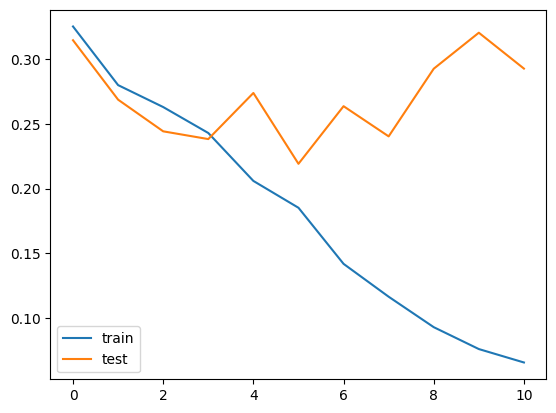

In [36]:
import matplotlib.pyplot as plt 
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

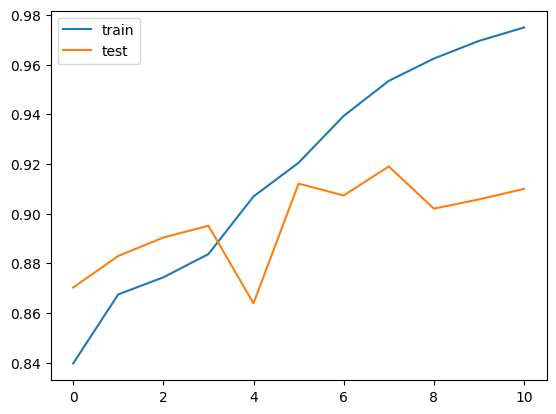

In [37]:
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [51]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False


model = base_model.output
# model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(512, activation='relu')(model)
model = tf.keras.layers.Dense(2, activation='softmax')(model)


model = Model(inputs=base_model.input, outputs=model)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [38]:
model = tf.keras.models.load_model('/kaggle/working/model.h5')

In [ ]:
def difference(path):
    filename = path
    # print(path)
    resaved_name = filename.split('.')[-2]+'_resaved.jpg'
    # print(resaved_name)
    resaved_name = resaved_name.split('/')[-1]
    org = Image.open(filename).convert('RGB')
    org.save(resaved_name, 'JPEG', quality=92)
    resaved = Image.open(resaved_name)
    diff = ImageChops.difference(org, resaved)
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    diff = ImageEnhance.Brightness(diff).enhance(scale)
    # diff
    return diff

: 

In [ ]:
import numpy as np
from PIL import Image

def preprocess_image(path):
    try:
        # Open and resize the image
        img = Image.open(path)
        img_resized = img.resize((128, 128))
        
        # Assuming 'difference' function is defined elsewhere
        img_diff = np.array(difference(path).resize((128, 128))).flatten() / 255.0
        img_diff = img_diff.reshape(-1, 128, 128, 3)
        
        return img_resized, img_diff
    
    except FileNotFoundError:
        print("Image does not exist or wrong path provided.")
        exit()

# Example usage:
path = input("Enter image path:\n")
img_resized, img_diff = preprocess_image(path)


In [ ]:
pred = model.predict(img_diff)

In [ ]:
if pred[0][0] > 0.5:
    print("Prediction: Not Forged")
else:
    print("Prediction: Forged")